In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [6]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [7]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [9]:
# verbose : 훈련과정 출력을 조절. 기본값 1은 진행막대, 손실지표 등 출력. 2로 바꾸면 막대 없이 출력. 0은 미출력
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [10]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


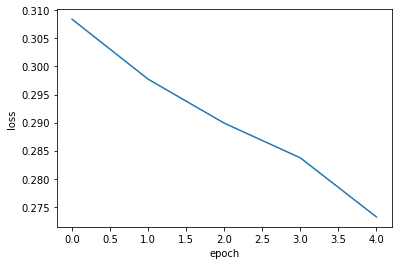

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

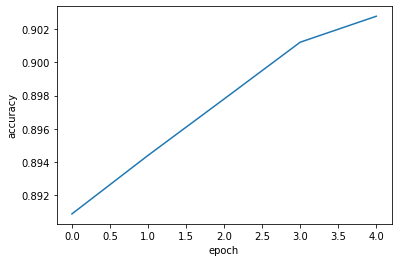

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

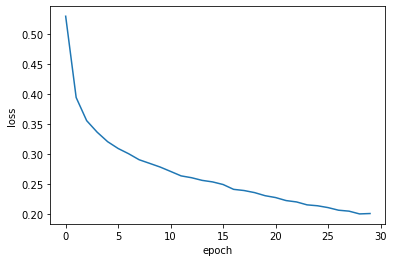

In [17]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=30, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


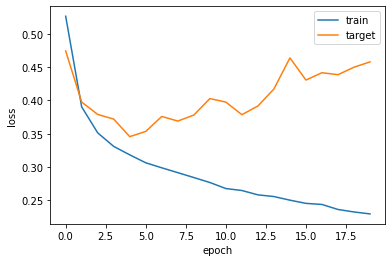

In [19]:
# 에포크 마다의 검증 손실 계산
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data = (val_scaled, val_target))
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'target'])
plt.show()

In [ ]:
# adam 옵티마이저 적용
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=25, verbose=0, 
                    validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [20]:
# 드랍아웃 drop out : 은닉층의 뉴런을 랜덤하게 제거하여 과대적합 방지. 특정층의 출력을 0으로 만들기. 0.3 은 30%
# 훈련이 끝난 후 평가/예측 시에는 드랍아웃 적용하지 말아야 함. 케라스에서 자동으로 스킵함
model = model_fn(keras.layers.Dropout(0.3))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-06', dpi=300)
plt.show()

In [21]:
# 모델 저장 
# : save_weights는 기본적으로 텐서플로의 체크포인트 포맷으로 저장하지만, 파일 확장자가 .h5 이면 HDF5 포맷으로 저장함
# : save는 텐서플로의 SavedModel포맷으로 저장하지만 파일 확장자가 .h5  이면 HDF5 포맷으로 저장함
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

model.save_weights('model-weights.h5')
model.save('model-whole.h5')

In [22]:
# 파일 생성 확인
!ls -al *.h5

-rw-r--r--  1 choegihyeong  staff  333448 12  4 14:08 model-weights.h5
-rw-r--r--  1 choegihyeong  staff  982664 12  4 14:08 model-whole.h5


In [24]:
# load_weights 메소드를 사용하려면, save_weights 로 저장했던 모델과 정확히 같은 구조를 가지고 있어야 함.
# 그래서 model_fn 사용해서 동일한 모델 만들기
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

In [26]:
# 이 모델의 검증 정확도 확인하기 predict 메소드 사용
# 왜 evaluate 사용하지 않는가? evaluate 사용하려면 complie 단계가 필수!
# argmax 는 결과에서 가장 큰 값 고르는 함수
# axis = 1 이면, 열을 따라 각 행의 최대값의 인덱스 선택
# axis = 0 이면, 행을 따라 각 열의 최대값의 인덱스 선택
# axis = -1 이면, 배열의 마지막 차원을 따라 최대값 선택. 검증 세트는 2차원 배열이기 때문에 마지막 차원은 1이 됨
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))


0.87775


In [27]:
# load_model 은 모델 파라미터 뿐 아니라 모델 구조와 옵티마이저 상태까지 모두 복원하기 때문에 evaluate 사용 가능함
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3375 - accuracy: 0.8777


[0.3374810814857483, 0.8777499794960022]

In [29]:
# 콜백 call back : 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체.
# ModelCheckPoint 콜백 : 에포크마다 모델을 저장. save_best_only=True 매개변수 지정 시 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있음
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

In [30]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3164 - accuracy: 0.8904


[0.3163909912109375, 0.89041668176651]

In [33]:
# 조기종료 early stopping : 검증 정수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지기 때문에 훈련 불필요. 이때 훈련 중지하면 자원/시간 절약.
#   -> 과대 적합 전에 훈련을 미리 중지하는 것. 훈련 에포크 횟수를 제한.
# EarlyStopping 콜백 
# - patience 매개변수는 검증 점수가 향상하지 않더라도 참을 에포크 횟수로 지정. = 2 이면, 2번 연속 검증 점수가 안 오르면 중지!
# - restore_best_weights=True 이면 가장 낮은 검증 손실을 낸 모델 파라미터로 원복
# - 앞선 ModelCheckPoint와 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고, 검증 손실이 다시 상승할 때 훈련을 중지할 수 있음. 
#   그리고 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌림
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [35]:
print(early_stopping_cb.stopped_epoch)

10


<function matplotlib.pyplot.show(close=None, block=None)>

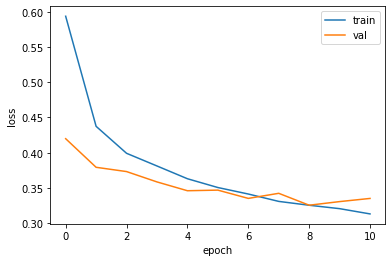

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show

In [37]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3256 - accuracy: 0.8796


[0.3255712389945984, 0.8795833587646484]